Ici on fait de l'ACP sur les données

In [88]:
library("dplyr")
library("FactoMineR")

In [89]:
# CHARGER les données
data_20_stations <- read.csv("../data/mesures/donnees_extracted_20.csv")

## Nettoyage du Df pour l'ACP

Processus de nettoyage dans l'ordre:

* Retrait des colonnes non numeriques

* Retrait des colonnes d'identifiants

* Retrait des colonnes de variables qualitatives

* Retrait des colonnes à proportion de NaN élevée 

* Retrait des lignes contenant des NaNs

* Retrait des colonnes éventuellement constantes (souvent le cas sur des petits jeux de données)

Enfin sur les colonnes restantes, d'autres colonnes seront retirées dans un processus de sélection détaillé ci-dessous. 

In [99]:
clean_data <- function(
  df, 
  verbose = TRUE,
  id_cols = c(
    "ID.OMM.station", 
    "communes..code.", 
    "EPCI..code.", 
    "department..code.", 
    "region..code."
  ),
  cat_cols = c(
    "Type.de.tendance.barométrique", 
    "Temps.présent", 
    "Temps.passé.1", 
    "Temps.passé.2", 
    "Type.des.nuages.de.l.étage.inférieur", 
    "Type.des.nuages.de.l.étage.moyen", 
    "Type.des.nuages.de.l.étage.supérieur", 
    "Type.nuage.1", 
    "Type.nuage.2", 
    "Type.nuage.3", 
    "Type.nuage.4", 
    "mois_de_l_annee", 
    "Nebulosité.totale", 
    "Nébulosité..des.nuages.de.l..étage.inférieur", 
    "Nébulosité.couche.nuageuse.1", 
    "Nébulosité.couche.nuageuse.2", 
    "Nébulosité.couche.nuageuse.3", 
    "Nébulosité.couche.nuageuse.4",
    "Etat.du.sol",
    "Periode.de.mesure.de.la.neige.fraiche",
    "Periode.de.mesure.de.la.rafale"
  ),
  NaN_cols = c(
    "Température.minimale.sur.12.heures",
    "Température.maximale.sur.12.heures",
    "Température.minimale.sur.24.heures",
    "Température.maximale.sur.24.heures",
    "Température.minimale.sur.12.heures...C.",
    "Température.maximale.sur.12.heures...C.",
    "Température.minimale.sur.24.heures...C.",
    "Température.maximale.sur.24.heures...C.",
    "Hauteur.de.base.1",
    "Hauteur.de.base.2",
    "Hauteur.de.base.3",
    "Hauteur.de.base.4",
    "Niveau.barométrique",
    "Géopotentiel",
    "Précipitations.dans.la.dernière.heure",
    "Précipitations.dans.les.3.dernières.heures",
    "Précipitations.dans.les.6.dernières.heures",
    "Précipitations.dans.les.12.dernières.heures",
    "Précipitations.dans.les.24.dernières.heures"
  ),
  other_cols = c()
) {
  cat("Data Frame Size:", dim(df), "\n")
  
  # Select only numeric columns
  df_numeric <- df %>% select_if(is.numeric)
  removed_cols <- setdiff(colnames(df), colnames(df_numeric))
  if (length(removed_cols) > 0) {
    cat("#### Removed non numeric columns: ####\n")
    cat(paste(removed_cols, collapse = "\n"), "\n")
  }
  df <- df_numeric
  if (verbose) cat("Columns after numeric selection:", colnames(df), "\n")
  
  # Remove ID columns
  df_noId <- df[, !names(df) %in% id_cols]
  removed_cols <- setdiff(colnames(df), colnames(df_noId))
  if (length(removed_cols) > 0) {
    cat("#### Removed Id columns: ####\n")
    cat(paste(removed_cols, collapse = "\n"), "\n")
  }
  df <- df_noId
  if (verbose) cat("Columns after removing ID columns:", colnames(df), "\n")
  
  # Remove categorical columns
  df_quantitative <- df[, !names(df) %in% cat_cols]
  removed_cols <- setdiff(colnames(df), colnames(df_quantitative))
  if (length(removed_cols) > 0) {
    cat("#### Removed qualitative columns: ####\n")
    cat(paste(removed_cols, collapse = "\n"), "\n")
  }
  df <- df_quantitative
  if (verbose) cat("Columns after removing categorical columns:", colnames(df), "\n")

  # Remove columns with too many NaNs
  df_noNaNs <- df[, !names(df) %in% NaN_cols]
  removed_cols <- setdiff(colnames(df), colnames(df_noNaNs))
  if (length(removed_cols) > 0) {
    cat("#### Removed NaN columns: ####\n")
    cat(paste(removed_cols, collapse = "\n"), "\n")
  }
  df <- df_noNaNs
  if (verbose) cat("Columns after removing NaN columns:", colnames(df), "\n")

  # Remove other columns
  if (length(other_cols) > 0) {
    df_nOther <- df[, !names(df) %in% other_cols]
    removed_cols <- setdiff(colnames(df), colnames(df_nOther))
    if (length(removed_cols) > 0) {
      cat("#### Removed other columns: ####\n")
      cat(paste(removed_cols, collapse = "\n"), "\n")
    }
    df <- df_nOther
    if (verbose) cat("Columns after removing other columns:", colnames(df), "\n")
  } else {
    cat("No other columns to remove\n")
  }
  
  # Remove rows with NA
  cat("Cleaning NaN rows...\n")
  df <- na.omit(df)
  cat("Data Frame Size after NA removal:", dim(df), "\n")

  # Remove constant columns
  const_columns <- sapply(df, function(x) length(unique(x)) == 1)
  df_noConst <- df[, !const_columns]
  removed_cols <- setdiff(colnames(df), colnames(df_noConst))
  if (length(removed_cols) > 0) {
    cat("#### Removed constant columns: ####\n")
    cat(paste(removed_cols, collapse = "\n"), "\n")
  }
  df <- df_noConst
  if (verbose) cat("Columns after removing constant columns:", colnames(df), "\n")
  cat("Data Frame Size:", dim(df), "\n")

  cat("Remaining columns:", colnames(df), "\n")
  
  return(df)
}


Notre but avec cet ACP est de déterminer quelles sont les variables météorologiques les plus pertinentes à conserver.

En revanche après le processus de nettoyage des données ci-dessus, nous retireront ensuite les colonnes suivantes:

"Rafales.sur.une.période", "Variation.de.pression.en.3.heures", "Direction.du.vent.moyen.10.mn", "Vitesse.du.vent.moyen.10.mn", "Variation.de.pression.en.24.heures", "Rafale.sur.les.10.dernières.minutes"

Car les échelles de temps ne sont pas les mêmes avec les autres variables météo

Température...C.,  "Température.minimale.du.sol.sur.12.heures", "Température.minimale.du.sol.sur.12.heures..en..C.

Celles-ci font doublon avec la colonnes température.

"Pression.au.niveau.mer"

Nous conserverons la pression mesurée à la station pour plus de précision

"Hauteur.totale.de.la.couche.de.neige..glace..autre.au.sol", "Hauteur.de.la.neige.fraîche

Non pertinente car toutes les stations ne sont pas forcément eneigées




In [ ]:

# Usage:
data_cleaned <- clean_data(data_20_stations, verbose = FALSE, other_cols = c("Rafales.sur.une.période", "Variation.de.pression.en.3.heures", "Direction.du.vent.moyen.10.mn", "Vitesse.du.vent.moyen.10.mn", "Variation.de.pression.en.24.heures", "Rafale.sur.les.10.dernières.minutes", "Température...C.", "Hauteur.totale.de.la.couche.de.neige..glace..autre.au.sol", "Hauteur.de.la.neige.fraîche", "Température.minimale.du.sol.sur.12.heures", "Température.minimale.du.sol.sur.12.heures..en..C.", "Pression.au.niveau.mer"))

head(data_cleaned)

Data Frame Size: 456720 82 
#### Removed non numeric columns: ####
Date
Méthode.de.mesure.Température.du.thermomètre.mouillé
Température.du.thermomètre.mouillé
Phénomène.spécial.1
Phénomène.spécial.2
Phénomène.spécial.3
Phénomène.spécial.4
Coordonnees
Nom
Type.de.tendance.barométrique.1
Temps.passé.1.1
Temps.présent.1
communes..name.
communes..code.
EPCI..name.
department..name.
department..code.
region..name. 
#### Removed Id columns: ####
ID.OMM.station
EPCI..code.
region..code. 
#### Removed qualitative columns: ####
Type.de.tendance.barométrique
Temps.présent
Temps.passé.1
Temps.passé.2
Nebulosité.totale
Nébulosité..des.nuages.de.l..étage.inférieur
Type.des.nuages.de.l.étage.inférieur
Type.des.nuages.de.l.étage.moyen
Type.des.nuages.de.l.étage.supérieur
Periode.de.mesure.de.la.rafale
Etat.du.sol
Periode.de.mesure.de.la.neige.fraiche
Nébulosité.couche.nuageuse.1
Type.nuage.1
Nébulosité.couche.nuageuse.2
Type.nuage.2
Nébulosité.couche.nuageuse.3
Type.nuage.3
Nébulosité.couche.nuageus

,Température,Point.de.rosée,Humidité,Visibilité.horizontale,Hauteur.de.la.base.des.nuages.de.l.étage.inférieur,Pression.station,Altitude
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,293.35,286.55,65,41180,1250,97480,336
2,280.75,278.35,85,60000,450,101020,219
3,285.25,276.95,57,60000,1250,101590,42
4,280.05,277.35,83,60000,2250,100460,10
6,281.75,277.75,76,17180,1250,101520,89
7,283.85,276.35,60,20000,800,100260,10


Importance of components:
                          PC1    PC2    PC3    PC4     PC5     PC6     PC7
Standard deviation     1.6065 1.2876 1.1521 0.8860 0.76889 0.22956 0.07172
Proportion of Variance 0.3687 0.2369 0.1896 0.1121 0.08446 0.00753 0.00073
Cumulative Proportion  0.3687 0.6055 0.7951 0.9073 0.99174 0.99927 1.00000

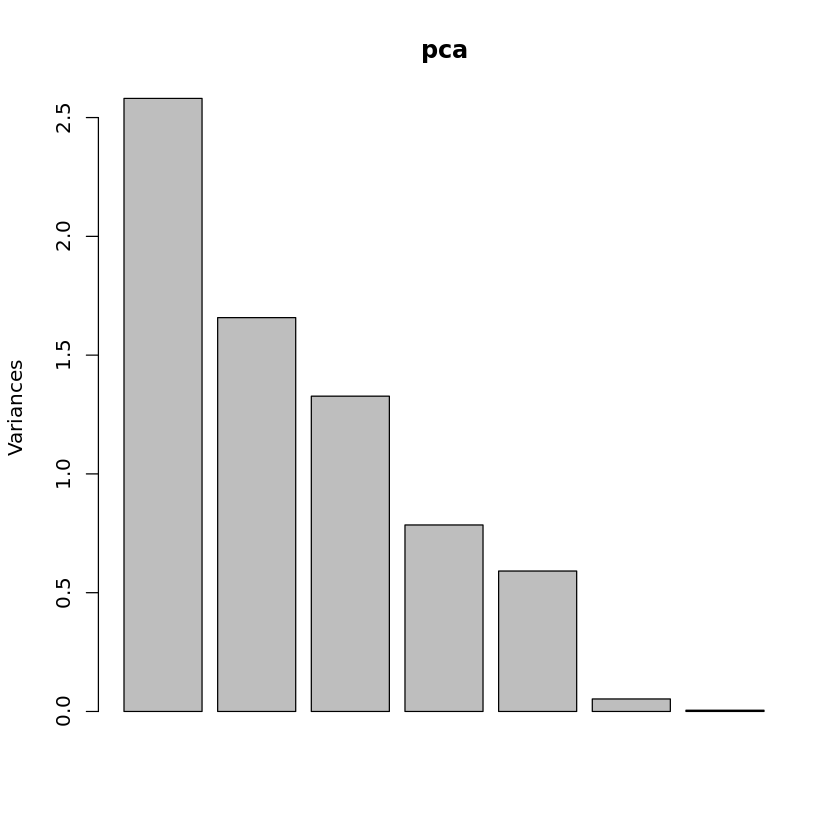

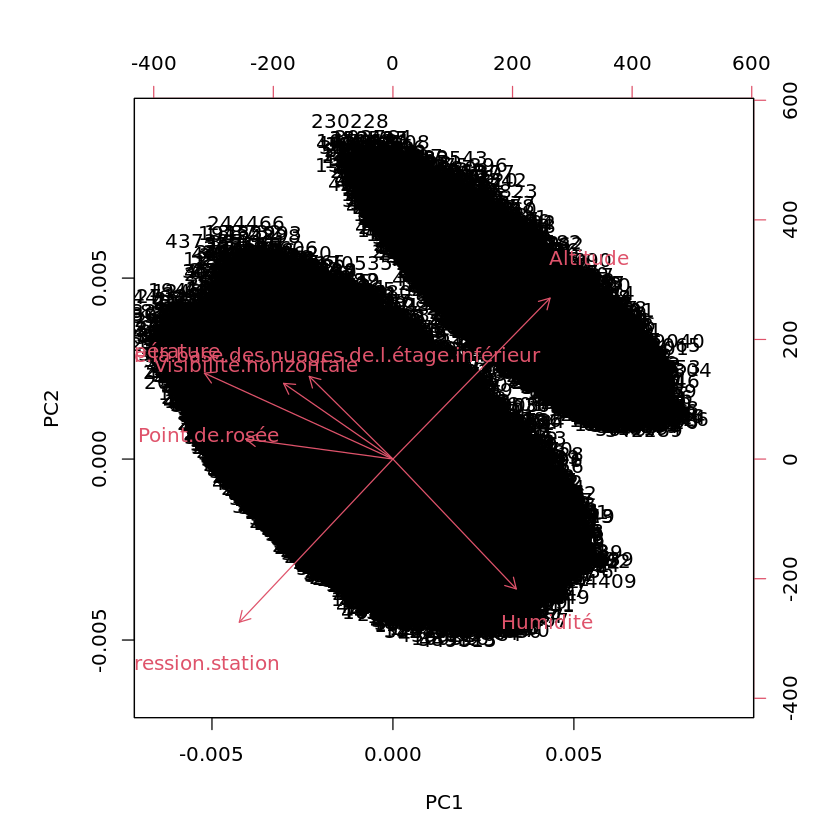

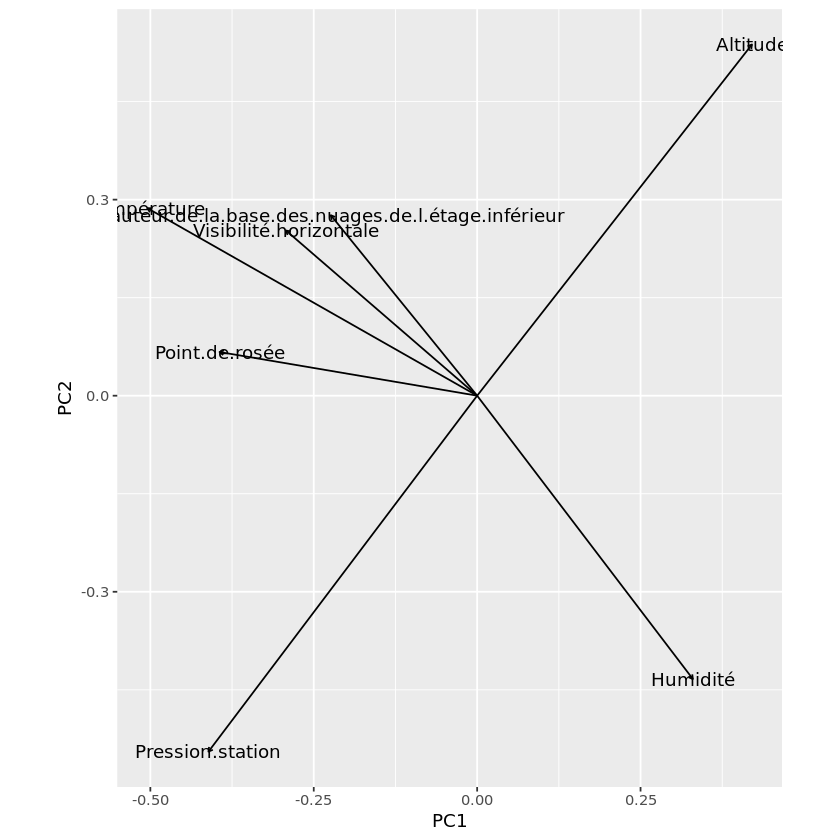

In [ ]:

library(ggbiplot)

# Perform PCA
pca <- prcomp(data_cleaned, scale. = TRUE)
summary(pca)
plot(pca)
biplot(pca)
# Extract scores (observations) and loadings (variables)
scores <- as.data.frame(pca$x)
loadings <- as.data.frame(pca$rotation)

# Plot only the variable arrows
ggplot() +
  geom_segment(data = loadings,
               aes(x = 0, y = 0, xend = PC1, yend = PC2),
               arrow = arrow(length = unit(0.1, "cm"))) +
  geom_text(data = loadings,
            aes(x = PC1, y = PC2, label = rownames(loadings)),
            hjust = 0.5, vjust = 0.5) +
  xlab("PC1") + ylab("PC2") +
  coord_fixed()


# TODO #
# Jouer avec les coordonnées géo

Résultats:

>Variables météo pertinentes *Humidité*, *Pression*, *Température*
